In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [14]:
factors = pd.read_csv('canslim_factors.csv')  # 因子数据
ret     = pd.read_csv('canslim_ret.csv')      # 收益数据

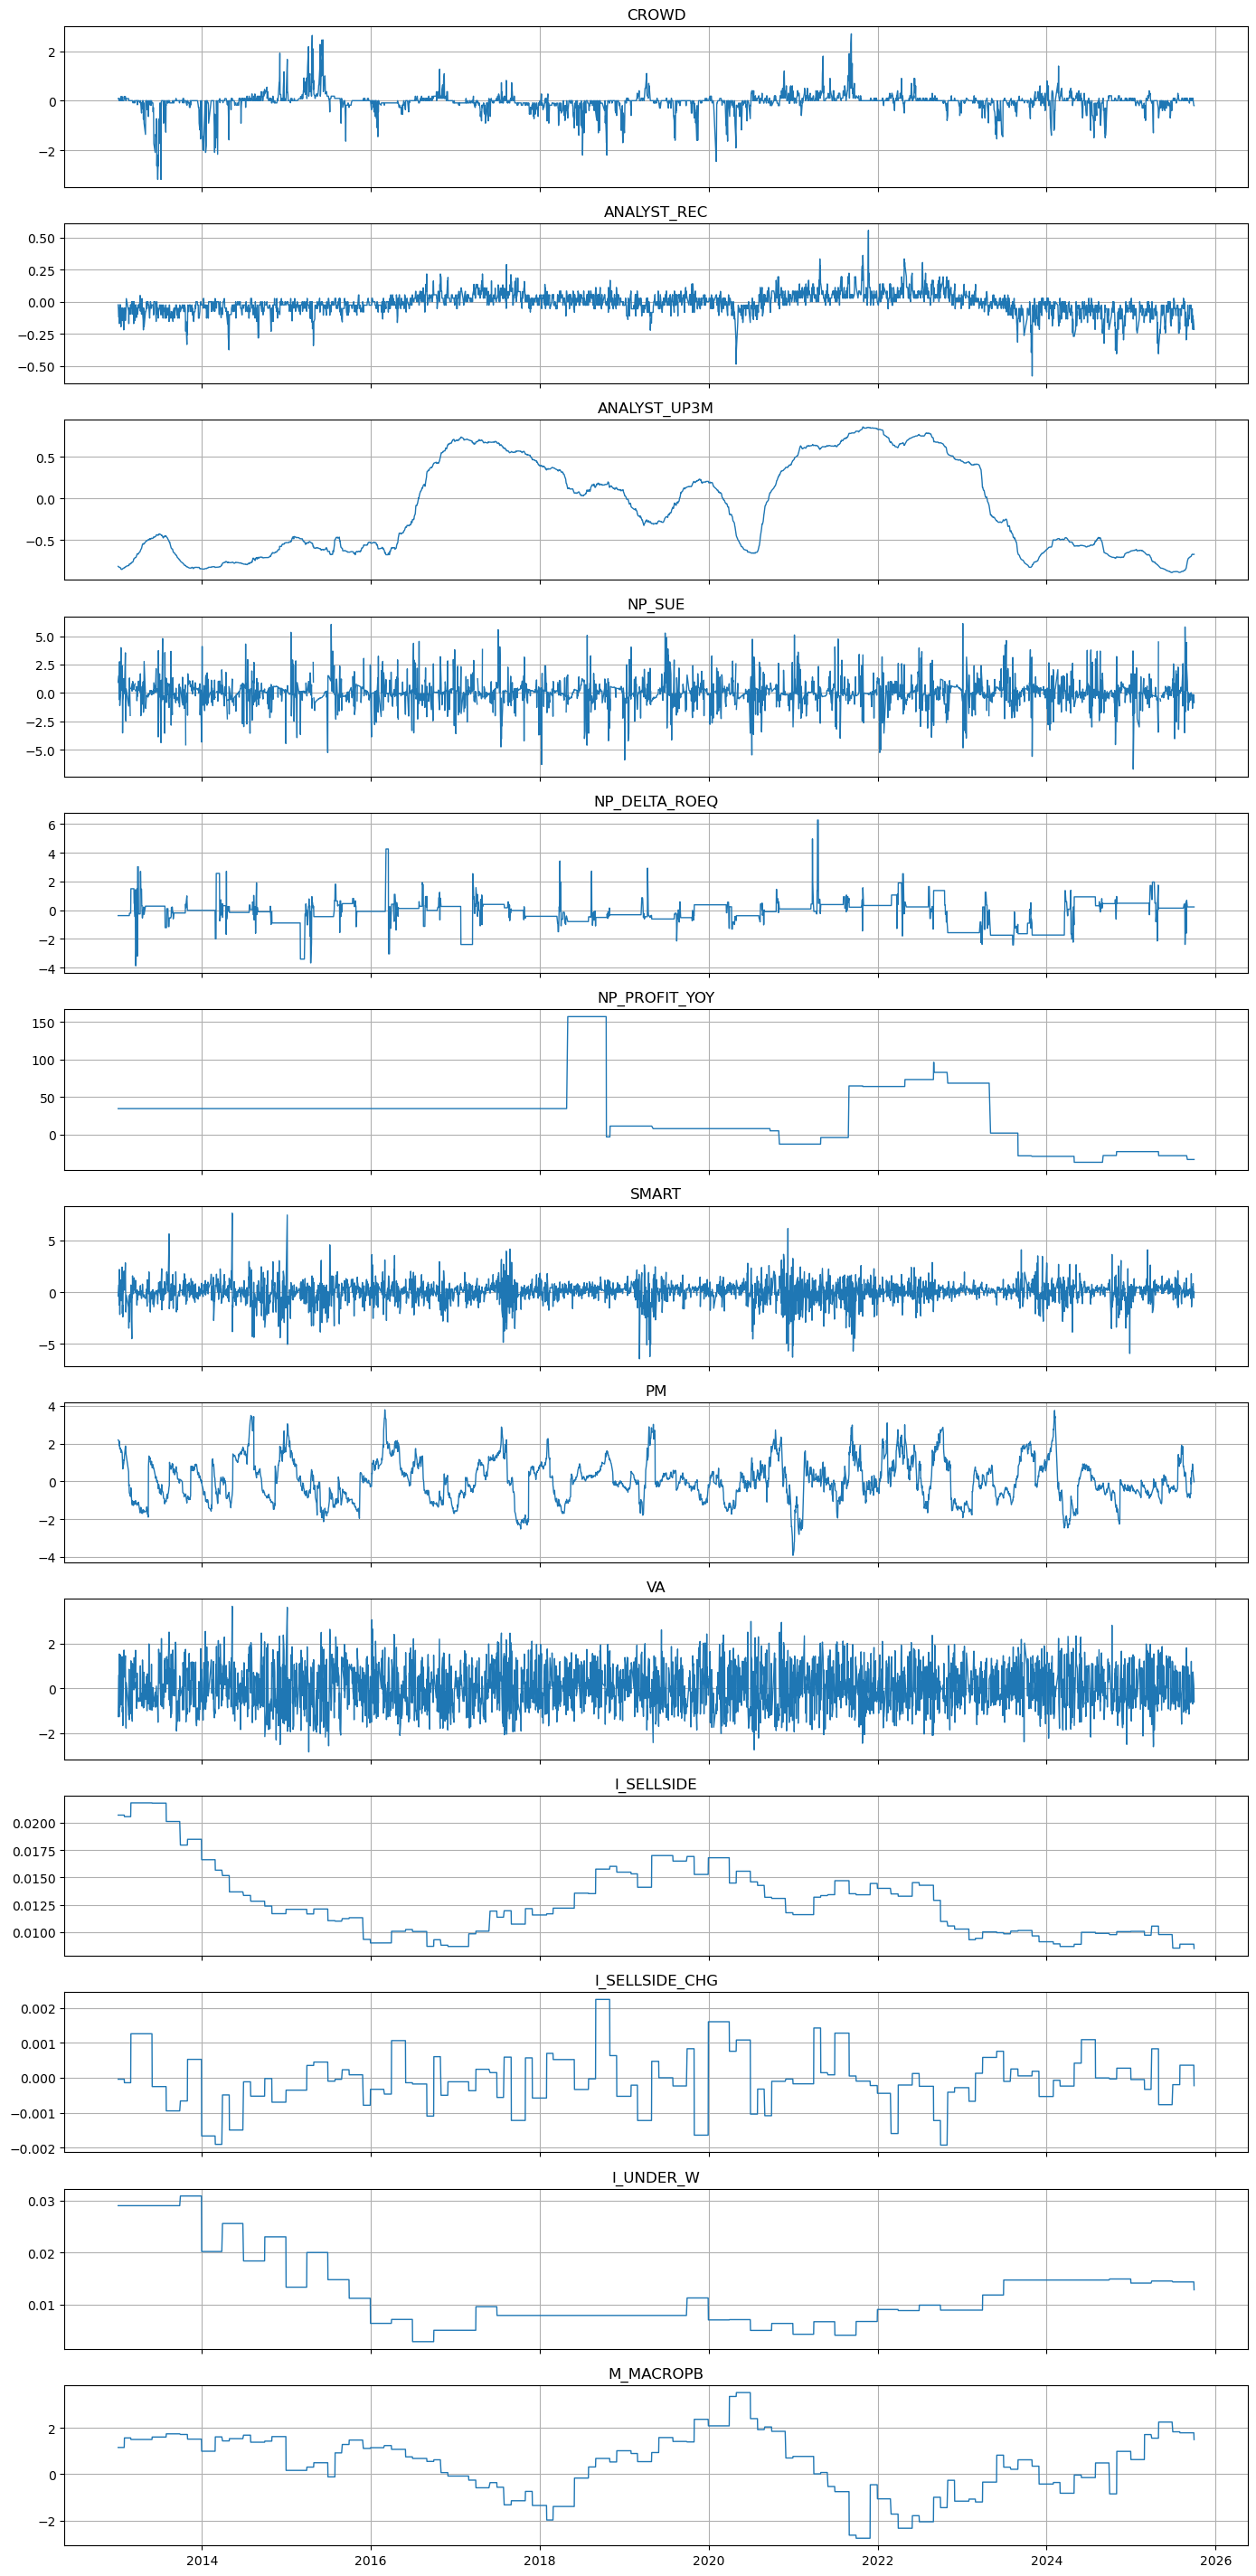

In [15]:
# 选一个指数画图
idx = "CI005002.WI" 
cols = [
    "CROWD",
    "ANALYST_REC",
    "ANALYST_UP3M",
    "NP_SUE",
    "NP_DELTA_ROEQ",
    "NP_PROFIT_YOY",
    "SMART",
    "PM",
    "VA",
    "I_SELLSIDE",
    "I_SELLSIDE_CHG",
    "I_UNDER_W",
    "M_MACROPB",
]

df = factors[factors["INDEX_CODE"] == idx].copy()
df["Date"] = pd.to_datetime(df["TRADE_DT"].astype(str))

n = len(cols)
fig, axes = plt.subplots(n, 1, figsize=(14, 2.2*n), sharex=True)

for i, c in enumerate(cols):
    if c not in df.columns:
        axes[i].set_title(f"{c} (missing)")
        axes[i].axis("off")
        continue
    axes[i].plot(df["Date"], df[c], linewidth=1)
    axes[i].set_title(c)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [16]:
# 统一 key 的数据类型，避免 merge 失败
factors["TRADE_DT"] = pd.to_numeric(factors["TRADE_DT"], errors="coerce").astype("Int64")
ret["TRADE_DT"]     = pd.to_numeric(ret["TRADE_DT"], errors="coerce").astype("Int64")

factors["INDEX_CODE"] = factors["INDEX_CODE"].astype(str)
ret["INDEX_CODE"]     = ret["INDEX_CODE"].astype(str)

# 去空值
factors = factors.dropna(subset=["TRADE_DT", "INDEX_CODE"]).copy()
ret     = ret.dropna(subset=["TRADE_DT", "INDEX_CODE", "RET"]).copy()

# 因子列（排除 ID/DATE）
FACTOR_COLS = [c for c in factors.columns if c not in ["TRADE_DT", "INDEX_CODE"]]
print("n_factors =", len(FACTOR_COLS))

n_factors = 13


In [17]:
# 构造交易日序列
all_dates = np.array(sorted(ret["TRADE_DT"].unique()))
all_dates = all_dates[~pd.isna(all_dates)].astype(int)

# 用“每月最后一个交易日”做调仓日
tmp = pd.DataFrame({"TRADE_DT": all_dates})
tmp["yyyymm"] = tmp["TRADE_DT"] // 100
rebal_dates = tmp.groupby("yyyymm")["TRADE_DT"].max().values
rebal_dates = np.array(sorted(rebal_dates)).astype(int)

# 把日收益做成面板：date x id
ret_pvt = ret.pivot_table(index="TRADE_DT", columns="INDEX_CODE", values="RET", aggfunc="mean").sort_index()

# 计算“从 dt 持有到 next_dt 的区间复利收益”
def period_return_from_daily(ret_panel: pd.DataFrame, start_dt: int, end_dt: int) -> pd.Series:
    seg = ret_panel.loc[(ret_panel.index > start_dt) & (ret_panel.index <= end_dt)]
    if seg.shape[0] == 0:
        return pd.Series(index=ret_panel.columns, dtype=float)
    return (1.0 + seg).prod(axis=0) - 1.0

# 以调仓日为 index，行业为 columns
fwd_list = []
for i in range(len(rebal_dates) - 1):
    dt, nxt = int(rebal_dates[i]), int(rebal_dates[i+1])
    fwd = period_return_from_daily(ret_pvt, dt, nxt)
    fwd.name = dt
    fwd_list.append(fwd)

# forward return
fwd_ret = pd.DataFrame(fwd_list)
fwd_ret.index.name = "TRADE_DT"

print("fwd_ret shape:", fwd_ret.shape)

fwd_ret shape: (152, 28)


In [18]:
# 因子取当月剔除最后三天的均值作为下一个月的调仓参考
K = 3  # 剔除月末最后 K 个交易日

df = factors[["TRADE_DT", "INDEX_CODE"] + FACTOR_COLS].copy()
df["yyyymm"] = (df["TRADE_DT"] // 100).astype(int)

# 每个月的交易日序列
month_dates = (
    df[["yyyymm", "TRADE_DT"]]
    .drop_duplicates()
    .sort_values(["yyyymm", "TRADE_DT"])
)

# 每个月 cutoff = 倒数第 K+1 个交易日
cutoff = (
    month_dates.groupby("yyyymm")["TRADE_DT"]
    .apply(lambda s: s.iloc[-(K+1)] if len(s) > K else s.iloc[-1])
    .rename("CUTOFF_DT")
    .reset_index()
)

df = df.merge(cutoff, on="yyyymm", how="left")

# 只用 <= cutoff 的月内数据
df_use = df[df["TRADE_DT"] <= df["CUTOFF_DT"]]

# 求均值
fac_month = (
    df_use.groupby(["yyyymm", "INDEX_CODE"])[FACTOR_COLS]
    .mean()
    .reset_index()
)

# 对齐到调仓日
rebal_map = pd.DataFrame({"TRADE_DT": rebal_dates})
rebal_map["yyyymm"] = (rebal_map["TRADE_DT"] // 100).astype(int)

fac = fac_month.merge(rebal_map, on="yyyymm", how="inner")
fac = fac[["TRADE_DT", "INDEX_CODE"] + FACTOR_COLS].copy()

# pivot + 横截面 rank
fac_pvt = fac.pivot_table(
    index=["TRADE_DT", "INDEX_CODE"],
    values=FACTOR_COLS,
    aggfunc="mean"
).sort_index()

rank_fac = fac_pvt.groupby(level=0).rank(pct=True)

print("fac_pvt shape:", fac_pvt.shape, "rank_fac shape:", rank_fac.shape)

fac_pvt shape: (4284, 13) rank_fac shape: (4284, 13)


In [19]:
IC_WIN = 12           # 滚动窗口
MIN_OBS = 8           # 窗口内至少多少期有值
IC_ABS_MIN = 0.01     # IC 下限
IR_MIN = 0.20         # ICIR 阈值

# 收益和时间对齐
common_dates = sorted(set(rank_fac.index.get_level_values(0)) & set(fwd_ret.index))
rank_fac = rank_fac.loc[(common_dates, slice(None)), :]
fwd_ret  = fwd_ret.loc[common_dates]

fwd_stack = fwd_ret.stack()
fwd_stack.index.names = ["TRADE_DT", "INDEX_CODE"]

# 计算 IC
def cs_spearman_ic_one_date(x_rank: pd.Series, y_ret: pd.Series) -> float:
    xy = pd.concat([x_rank, y_ret], axis=1)
    xy = xy.dropna()
    if xy.shape[0] < 6:
        return np.nan
    return xy.iloc[:,0].corr(xy.iloc[:,1], method="spearman")

# 构造 IC 序列
ic_df = pd.DataFrame(index=common_dates, columns=FACTOR_COLS, dtype=float)
for dt in common_dates:
    y = fwd_ret.loc[dt]
    x_dt = rank_fac.xs(dt, level=0) 
    for f in FACTOR_COLS:
        ic_df.loc[dt, f] = cs_spearman_ic_one_date(x_dt[f], y)

# 计算 ICIR
ic_mean = ic_df.rolling(IC_WIN, min_periods=MIN_OBS).mean()
ic_std  = ic_df.rolling(IC_WIN, min_periods=MIN_OBS).std()
ic_ir   = ic_mean / ic_std

# 筛选有效因子
is_eff = (ic_mean.abs() >= IC_ABS_MIN) & (ic_ir.abs() >= IR_MIN)

# 因子方向，+1表示因子值越高收益越好，-1相反
direction = np.sign(ic_mean).replace(0, np.nan)

print("IC computed. Example effective factor count (last 5 dates):")
print(is_eff.sum(axis=1).tail())

IC computed. Example effective factor count (last 5 dates):
20250430     5
20250530     5
20250630     5
20250731     7
20250829    10
dtype: int64


In [20]:
TOPK_PER_FACTOR = 6       # 每个因子投票给前 6 个行业
TOPN_PORT = 6             # 最终组合持有 6 个行业（等权）

# 去掉重复列名
def safe_dedup_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[:, ~pd.Index(df.columns).duplicated()].copy()

def build_votes_one_date(dt: int) -> pd.DataFrame:
    x = rank_fac.xs(dt, level=0) 
    x = safe_dedup_columns(x)

    # 只保留当期有效因子
    eff_f = [f for f in FACTOR_COLS if bool(is_eff.loc[dt, f]) and pd.notna(direction.loc[dt, f])]

    if len(eff_f) == 0:
        return pd.DataFrame(columns=["TRADE_DT", "INDEX_CODE"] + FACTOR_COLS + ["TOTAL_SCORE"])

    # 投票矩阵
    votes = pd.DataFrame(0, index=x.index, columns=FACTOR_COLS, dtype=int)

    for f in eff_f:
        s = x[f].dropna()
        if s.shape[0] < TOPK_PER_FACTOR:
            continue
        if direction.loc[dt, f] > 0:
            pick = s.sort_values(ascending=False).head(TOPK_PER_FACTOR).index
        else:
            pick = s.sort_values(ascending=True).head(TOPK_PER_FACTOR).index
        votes.loc[pick, f] = 1

    votes["TOTAL_SCORE"] = votes.sum(axis=1)

    out = votes.reset_index()
    out.insert(0, "TRADE_DT", dt)
    out = safe_dedup_columns(out)
    return out

# 生成所有调仓期 votes
votes_all = []
for dt in common_dates[:-1]:   # 最后一期没有 next period
    votes_all.append(build_votes_one_date(int(dt)))
votes_all = pd.concat(votes_all, ignore_index=True)

print(votes_all[["TRADE_DT", "INDEX_CODE", "TOTAL_SCORE"]].head())


   TRADE_DT   INDEX_CODE TOTAL_SCORE
0  20130830  CI005001.WI           2
1  20130830  CI005002.WI           1
2  20130830  CI005003.WI           1
3  20130830  CI005004.WI           2
4  20130830  CI005005.WI           3


In [21]:
# 每期持仓
holdings = {}
for dt in common_dates[:-1]:
    sub = votes_all[votes_all["TRADE_DT"] == int(dt)].copy()
    # 票数从高到低选 TOPN，票数相同按代码稳定排序
    sub = sub.sort_values(["TOTAL_SCORE", "INDEX_CODE"], ascending=[False, True])
    picks = sub.loc[sub["TOTAL_SCORE"] > 0, "INDEX_CODE"].head(TOPN_PORT).tolist()
    # 如果这一期有效因子太少导致 picks 为空，用“行业等权”
    if len(picks) == 0:
        picks = ret_pvt.columns.tolist()
    holdings[int(dt)] = picks

# 生成策略日收益：每个区间内用上期持仓等权
ret_pvt = ret_pvt.sort_index()

# 策略日收益序列
strategy_daily = pd.Series(index=ret_pvt.index, dtype=float)

# 基准：所有行业等权
bench_daily = ret_pvt.mean(axis=1)

for i in range(len(common_dates) - 1):
    dt, nxt = int(common_dates[i]), int(common_dates[i+1])
    ids = holdings.get(dt, ret_pvt.columns.tolist())
    seg = ret_pvt.loc[(ret_pvt.index > dt) & (ret_pvt.index <= nxt), ids]
    if seg.shape[0] == 0:
        continue
    strategy_daily.loc[seg.index] = seg.mean(axis=1)

df_nav = pd.DataFrame({"strat": strategy_daily, "bench": bench_daily}).dropna()
strategy_daily = df_nav["strat"]
bench_daily = df_nav["bench"]

# 只在真实交易日上对齐
common_idx = strategy_daily.index.intersection(bench_daily.index)
strategy_daily = strategy_daily.loc[common_idx].sort_index()
bench_daily = bench_daily.loc[common_idx].sort_index()

# 如果还有少量 NaN，删掉这天
mask = strategy_daily.notna() & bench_daily.notna()
strategy_daily = strategy_daily[mask]
bench_daily = bench_daily[mask]

# 净值
nav_strat = (1.0 + strategy_daily).cumprod()
nav_bench = (1.0 + bench_daily).cumprod()
excess = nav_strat / nav_bench

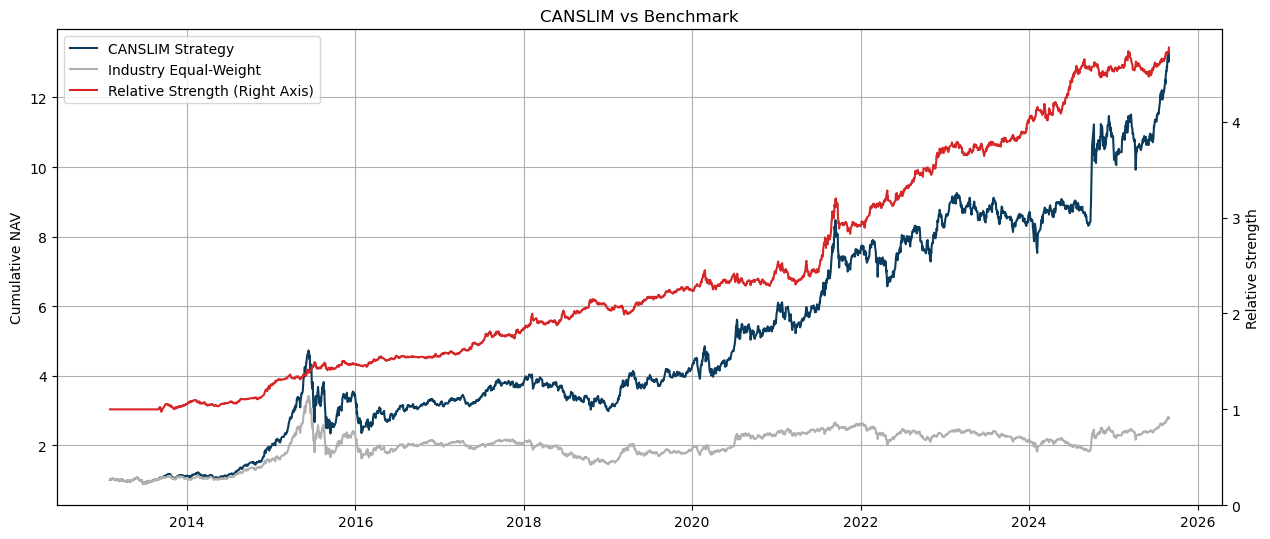

In [22]:
# 画图
x = pd.to_datetime(nav_strat.index.astype(str))

fig, ax1 = plt.subplots(figsize=(12.8, 5.5))

# 左轴：累计净值
l1, = ax1.plot(x, nav_strat.values, color="#0B3C5D", label="CANSLIM Strategy")
l2, = ax1.plot(x, nav_bench.reindex(nav_strat.index).values, color="#B0B0B0", label="Industry Equal-Weight")
ax1.set_ylabel("Cumulative NAV")
ax1.grid(True)

# 右轴：相对强弱
ax2 = ax1.twinx()
l3, = ax2.plot(x, excess.reindex(nav_strat.index).values, color="#D62728", label="Relative Strength (Right Axis)")
ax2.set_ylabel("Relative Strength")
ax2.set_ylim(bottom=0)

# 合并图例
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper left")

ax1.set_title("CANSLIM vs Benchmark")
plt.tight_layout()
plt.show()

In [23]:
# 计算指标
def ann_return_from_nav(nav: pd.Series, periods_per_year: int = 252) -> float:
    nav = nav.dropna()
    n = len(nav)
    if n < 2:
        return np.nan
    return nav.iloc[-1] ** (periods_per_year / n) - 1.0

def max_dd_from_nav(nav: pd.Series) -> float:
    nav = nav.dropna()
    if len(nav) < 2:
        return np.nan
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return dd.min() 

def ann_vol(r: pd.Series, periods_per_year: int = 252) -> float:
    r = r.dropna()
    if len(r) < 2:
        return np.nan
    return r.std() * np.sqrt(periods_per_year)

def info_ratio(active_r: pd.Series, periods_per_year: int = 252) -> float:
    active_r = active_r.dropna()
    if len(active_r) < 2:
        return np.nan
    te = active_r.std()
    if te == 0 or np.isnan(te):
        return np.nan
    return (active_r.mean() / te) * np.sqrt(periods_per_year)

def monthly_win_rate(strat_daily: pd.Series, bench_daily: pd.Series) -> float:
    s = strat_daily.dropna()
    b = bench_daily.dropna()
    idx = s.index.intersection(b.index)
    s = s.loc[idx]
    b = b.loc[idx]
    if len(idx) < 2:
        return np.nan

    # 关键修复：把 index 转成 datetime
    try:
        s.index = pd.to_datetime(s.index.astype(str), format="%Y%m%d", errors="coerce")
        b.index = pd.to_datetime(b.index.astype(str), format="%Y%m%d", errors="coerce")
    except Exception:
        s.index = pd.to_datetime(s.index.astype(str), errors="coerce")
        b.index = pd.to_datetime(b.index.astype(str), errors="coerce")

    # 去掉无法解析日期的行
    s = s[~s.index.isna()]
    b = b[~b.index.isna()]
    if len(s) < 2 or len(b) < 2:
        return np.nan

    # 日收益 -> 月收益（复利）
    s_m = (1.0 + s).resample("M").prod() - 1.0
    b_m = (1.0 + b).resample("M").prod() - 1.0
    m = s_m.index.intersection(b_m.index)
    if len(m) == 0:
        return np.nan
    return float((s_m.loc[m] > b_m.loc[m]).mean())


active_daily = (strategy_daily - bench_daily).dropna()

# 年化
ann_strat = ann_return_from_nav(nav_strat)
ann_bench = ann_return_from_nav(nav_bench)
ann_excess = ann_strat - ann_bench  # 年化超额

# 回撤
mdd_strat = max_dd_from_nav(nav_strat)
mdd_bench = max_dd_from_nav(nav_bench)
mdd_excess = max_dd_from_nav(excess)  # 超额净值回撤

# IR / 收益回撤比 / 月胜率
ir = info_ratio(active_daily)
ret_dd = ann_strat / abs(mdd_strat) if (mdd_strat is not None and not np.isnan(mdd_strat) and mdd_strat < 0) else np.nan
mwr = monthly_win_rate(strategy_daily, bench_daily)

# 输出
print("========== Performance Summary ==========")
print(f"Ann.Return (Strat) : {ann_strat*100:.2f}%")
print(f"Ann.Return (Bench) : {ann_bench*100:.2f}%")
print(f"Ann.Excess (S-B)   : {ann_excess*100:.2f}%")
print("----------------------------------------")
print(f"MaxDD (Strat)      : {mdd_strat*100:.2f}%")
print(f"MaxDD (Bench)      : {mdd_bench*100:.2f}%")
print(f"MaxDD (Excess NAV) : {mdd_excess*100:.2f}%")
print("----------------------------------------")
print(f"Information Ratio  : {ir:.2f}")
print(f"Return/Drawdown    : {ret_dd:.2f}")
print(f"Monthly Win Rate   : {mwr*100:.1f}%")
print("========================================")


========== Performance Summary ==========
Ann.Return (Strat) : 23.82%
Ann.Return (Bench) : 8.85%
Ann.Excess (S-B)   : 14.98%
----------------------------------------
MaxDD (Strat)      : -50.48%
MaxDD (Bench)      : -58.09%
MaxDD (Excess NAV) : -11.54%
----------------------------------------
Information Ratio  : 1.61
Return/Drawdown    : 0.47
Monthly Win Rate   : 63.6%
